In [1]:
from pyspark.sql import SparkSession

In [5]:
import os
import urllib.request
import zipfile

In [2]:
spark = SparkSession.builder.appName("MovieLensAnalysis").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/13 14:00:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
dataset_url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
zip_path = "/tmp/ml-latest-small.zip"
extract_path = "/tmp/ml-latest-small/"

In [6]:
# Step 1: Download the dataset
if not os.path.exists(zip_path):
    print("Downloading MovieLens dataset...")
    urllib.request.urlretrieve(dataset_url, zip_path)
    print("Download complete!")

# Step 2: Extract the ZIP file
if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/tmp/")
    print("Extraction complete!")

Download complete!
Extracting dataset...
Extraction complete!


In [8]:
movies_path = os.path.join(extract_path, "movies.csv")
ratings_path = os.path.join(extract_path, "ratings.csv")
tags_path = os.path.join(extract_path, "tags.csv")
links_path = os.path.join(extract_path, "links.csv")

In [9]:
movies_df = spark.read.csv(f"file://{movies_path}", header=True, inferSchema=True)
ratings_df = spark.read.csv(f"file://{ratings_path}", header=True, inferSchema=True)
tags_df = spark.read.csv(f"file://{tags_path}", header=True, inferSchema=True)
links_df = spark.read.csv(f"file://{links_path}", header=True, inferSchema=True)


In [10]:
print("Movies DataFrame:")
movies_df.printSchema()
movies_df.show(5)

print("Ratings DataFrame:")
ratings_df.printSchema()
ratings_df.show(5)

print("Tags DataFrame:")
tags_df.printSchema()
tags_df.show(5)

print("Links DataFrame:")
links_df.printSchema()
links_df.show(5)

# Step 6: Display basic statistics
print("Movies count:", movies_df.count())
print("Ratings count:", ratings_df.count())
print("Tags count:", tags_df.count())
print("Links count:", links_df.count())

# Describe the ratings DataFrame
ratings_df.describe().show()

Movies DataFrame:
root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

Ratings DataFrame:
root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      

24/11/13 14:03:29 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+----------------+------------------+--------------------+
|summary|            userId|         movieId|            rating|           timestamp|
+-------+------------------+----------------+------------------+--------------------+
|  count|            100836|          100836|            100836|              100836|
|   mean|326.12756356856676|19435.2957177992| 3.501556983616962|1.2059460873684695E9|
| stddev| 182.6184914635004|35530.9871987003|1.0425292390606342|2.1626103599513078E8|
|    min|                 1|               1|               0.5|           828124615|
|    max|               610|          193609|               5.0|          1537799250|
+-------+------------------+----------------+------------------+--------------------+



In [13]:
# movies_df.createOrReplaceTempView("movies_df")

# spark.sql("SELECT * FROM movies_df LIMIT 5").show()

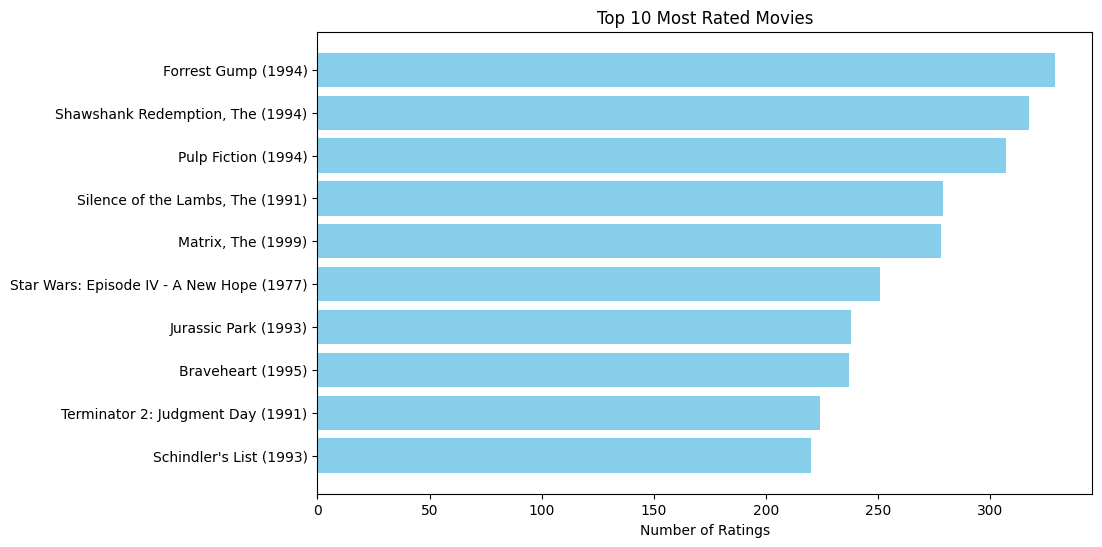

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Register the DataFrames as temporary views
movies_df.createOrReplaceTempView("movies_df")
ratings_df.createOrReplaceTempView("ratings_df")

# 1. Top 10 Most Rated Movies
top_rated_movies = spark.sql("""
    SELECT movies_df.title, COUNT(ratings_df.rating) as rating_count
    FROM ratings_df
    JOIN movies_df ON ratings_df.movieId = movies_df.movieId
    GROUP BY movies_df.title
    ORDER BY rating_count DESC
    LIMIT 10
""")

# Convert to Pandas for plotting
top_rated_movies_pd = top_rated_movies.toPandas()

# Plotting Top 10 Most Rated Movies
plt.figure(figsize=(10, 6))
plt.barh(top_rated_movies_pd['title'], top_rated_movies_pd['rating_count'], color='skyblue')
plt.xlabel("Number of Ratings")
plt.title("Top 10 Most Rated Movies")
plt.gca().invert_yaxis()
plt.show()

In [16]:
from pyspark.sql.types import *
from pyspark.sql.functions import col, mean, udf, lit, current_timestamp, unix_timestamp, array_contains
extract_genres = udf(lambda x: x.split("|"), ArrayType(StringType()))
movies_df_clean = movies_df.select("movieId", "title", extract_genres("genres").alias("genres"))
#display(movies_df_clean)

movies_df_clean.createOrReplaceTempView("movies_df_clean")

display (spark.sql("SELECT * FROM movies_df_clean limit 5"))

DataFrame[movieId: int, title: string, genres: array<string>]

In [17]:
genres_result = list(set(movies_df_clean.select('genres').rdd.flatMap(tuple).flatMap(tuple).collect()))
genres_result

['Action',
 'Sci-Fi',
 'IMAX',
 'Children',
 'Mystery',
 'Romance',
 'Thriller',
 'Animation',
 '(no genres listed)',
 'Fantasy',
 'Crime',
 'Drama',
 'Horror',
 'Film-Noir',
 'War',
 'Musical',
 'Adventure',
 'Western',
 'Comedy',
 'Documentary']

In [19]:
ratings_df.createOrReplaceTempView("ratings_df")
spark.sql("SELECT * FROM ratings_df limit 5").show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+



In [20]:
movie_ratings=ratings_df.drop('timestamp')

In [21]:
from pyspark.sql.types import IntegerType, FloatType
movie_ratings = movie_ratings.withColumn("userId", movie_ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", movie_ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", movie_ratings["rating"].cast(FloatType()))

In [22]:
movie_ratings.createOrReplaceTempView("movie_ratings")
spark.sql("SELECT * FROM movie_ratings limit 10").show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
+------+-------+------+



In [23]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [24]:
#Create test and train set
(training,test)=movie_ratings.randomSplit([0.8,0.2])

In [25]:
# Create ALS model
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5, rank=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")

In [26]:
# 1st print a list of parameters
print(als.explainParams())

alpha: alpha for implicit preference (default: 1.0)
blockSize: block size for stacking input data in matrices. Data is stacked within partitions. If block size is more than remaining data in a partition then it is adjusted to the size of this data. (default: 4096)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
coldStartStrategy: strategy for dealing with unknown or new users/items at prediction time. This may be useful in cross-validation or production scenarios, for handling user/item ids the model has not seen in the training data. Supported values: 'nan', 'drop'. (default: nan, current: drop)
finalStorageLevel: StorageLevel for ALS model factors. (default: MEMORY_AND_DISK)
implicitPrefs: whether to use implicit preference (default: False)
intermediateStorageLevel: StorageLe

In [27]:
#Tune model using ParamGridBuilder
# it will take long time in the cv period, so just use few parameter to try 

paramGrid = (ParamGridBuilder()
             .addGrid(als.regParam, [0.01])
             .addGrid(als.rank, [10])
             .addGrid(als.maxIter, [15])
             .build())

In [28]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

In [29]:
from pyspark.ml.tuning import CrossValidator
# Build Cross validation 
# Create 5-fold CrossValidator
# it takes too long that I only use 2-fold
cv = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=2)

# Run cross validations
cvModel = cv.fit(training)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

In [30]:
# Extract the best model selected by CV
best_model = cvModel.bestModel

In [31]:
#Fit ALS model to training data

# specify parameter settings by the best model obtained via CV
print ("**Best Model**")
print ("Rank: ", best_model)
print (" MaxIter: ", str(best_model._java_obj.parent().getMaxIter()))
print (" RegParam:",  best_model._java_obj.parent().regParam())

**Best Model**
Rank:  ALSModel: uid=ALS_848ce27b0ed5, rank=10
 MaxIter:  15
 RegParam: ALS_848ce27b0ed5__regParam


In [32]:
#Generate predictions and evaluate using RMSE
predictions=best_model.transform(test)
rmse = evaluator.evaluate(predictions)

In [33]:
#Print RMSE 
print ("RMSE = "+str(rmse))

RMSE = 1.1441373580558203


In [34]:
#Extract best model from the tuning exercise using ParamGridBuilder

als_best = ALS(maxIter=15, rank=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als_best.fit(training)

In [35]:
#predictions.show(10)

predictions.createOrReplaceTempView("predictions")

spark.sql("SELECT * FROM predictions limit 10").show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   580|   3175|   2.5|  3.825178|
|   133|    471|   4.0| 3.3213995|
|   593|   1580|   1.5| 2.4585454|
|   597|    471|   2.0| 4.7426314|
|   597|   2366|   5.0| 5.1023397|
|   155|   1580|   4.0|  3.928725|
|   101|   3175|   4.0| 3.3998475|
|    28|   1645|   2.5| 2.5447369|
|   183|   1580|   4.0| 3.9802399|
|    27|   1580|   3.0| 3.4040718|
+------+-------+------+----------+



In [36]:
alldata=best_model.transform(movie_ratings)
rmse = evaluator.evaluate(alldata)
print ("RMSE = "+str(rmse))

RMSE = 0.6505448513959037


In [37]:
alldata.registerTempTable("alldata")

/opt/conda/envs/csgy-6513-fall/lib/python3.11/site-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [39]:
#recommend 10 movies for each users
user_recs = best_model.recommendForAllUsers(10)
#user_recs.show(10)

user_recs.createOrReplaceTempView("user_recs")

spark.sql("SELECT * FROM user_recs limit 10").show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|     1|[{3477, 7.520809}...|
|     2|[{70946, 6.803684...|
|     3|[{1468, 10.056379...|
|     4|[{130634, 8.13940...|
|     5|[{86320, 7.906044...|
|     6|[{179819, 6.92620...|
|     7|[{2459, 11.814674...|
|     8|[{4678, 10.667696...|
|     9|[{6380, 8.14432},...|
|    10|[{7318, 7.771312}...|
+------+--------------------+

